In [1]:
from collections import Counter
import torch
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torch_directml
import random
from tqdm import tqdm
%matplotlib inline

In [2]:
random.seed(42)

In [3]:
dml = torch_directml.device()
dml

device(type='privateuseone', index=0)

In [4]:
words = open('./names.txt', 'r').read().split()
words[:5]

['emma', 'olivia', 'ava', 'isabella', 'sophia']

In [5]:
len(words), min(len(w) for w in words), max(len(w) for w in words)

(32033, 2, 15)

In [6]:
# build list of unique words
chars = sorted(list(set("".join(words))))
stoi = {c: i for i, c in enumerate(chars, start=1)}
stoi['.'] = 0
itos = {i: c for c, i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(f'Vocab size: {vocab_size}')

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
Vocab size: 27


In [7]:
# build dataset
block_size = 3

def build_dataset(words):
    X, Y = [], []

    for w in words:
        # print(w)
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            # print(f'{"".join(itos[i] for i in context)} --> {itos[ix]}')
            context = context[1:] + [ix]
    
    X = torch.tensor(X)
    Y = torch.tensor(Y)

    print(X.shape, Y.shape)
    return X, Y

In [8]:
random.shuffle(words)
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [42]:
n_embd = 10
n_hidden = 200
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27, n_embd), generator=g)
W1 = torch.randn((block_size * n_embd, n_hidden), generator=g) * (5 / 3) * (block_size * vocab_size)
# b1 = torch.randn(n_hidden, generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size), generator=g) * 0.01
b2 = torch.randn(vocab_size, generator=g) * 0

bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden))
bnmean_running = torch.ones((1, n_hidden))
bnstd_running = torch.ones((1, n_hidden))

parameters = [C, W1, W2, b2, bngain, bnbias]
for p in parameters:
    p.requires_grad = True

sum(p.nelement() for p in parameters)

12097

In [43]:
prev_grads = [torch.zeros_like(p) for p in parameters]

In [44]:
batch_size = 32
alpha = 1e-4
lr = 0.01
momentum = 0.5
eps = 1e-5

steps = []
lossi = []

for itr in tqdm(range(50000)):
    # forward pass
    ix = torch.randint(0, Xtr.shape[0], (batch_size, ))
    X_train, Y_train = Xtr[ix], Ytr[ix]

    emb = C[X_train]
    hpreact = emb.view(X_train.shape[0], -1) @ W1 #+ b1

    # Batchnorm layer
    bnmeani = hpreact.mean(0, keepdim=True)
    bnstdi = hpreact.std(0, keepdim=True)
    hpreact = bngain * (hpreact - bnmeani) / bnstdi + bnbias

    with torch.no_grad():
        bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
        bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi

    # Non linearity
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Y_train)

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    # lr = 0.1 if itr < 10000 else 0.01
    

    # for p in parameters:
    #     p.data -= lr * p.grad

    with torch.no_grad():
        for i in range(len(prev_grads)):
            prev_grads[i] = momentum * prev_grads[i] + \
                (1 - momentum) * torch.square(parameters[i].grad)
        for p, prev_grad in zip(parameters, prev_grads):
            p.data = p.data - (lr * p.grad / torch.sqrt(prev_grad + eps))

    # if itr % 100 == 0:
    #     print(f'Loss: {loss:.4f}')
    # track stats
    lossi.append(loss.log10().item())
    steps.append(itr)
    # break
loss.item()

100%|██████████| 50000/50000 [01:18<00:00, 635.70it/s]


2.905663013458252

In [19]:
hpreact.mean(0, keepdim=True).shape

torch.Size([1, 200])

In [11]:
with torch.no_grad():
    emb = C[Xtr]
    embcat = emb.view(Xtr.shape[0], -1)
    hpreact = embcat @ W1
    bnmean = hpreact.mean(0, keepdim=True)
    bnstd = hpreact.std(0, keepdim=True)

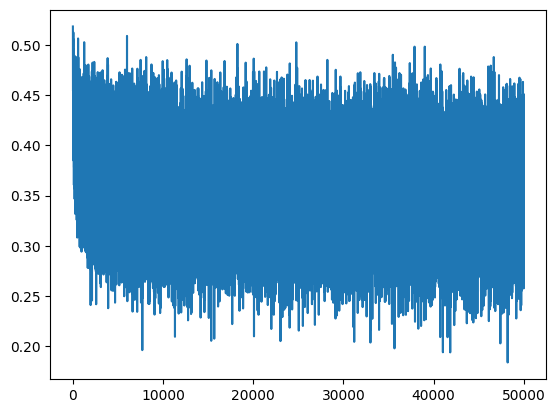

In [12]:
plt.plot(steps, lossi)
plt.show()

In [13]:
@torch.no_grad() # disables gradient tracking
def split_loss(split):
    x, y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte)
    }[split]

    emb = C[x]
    hpreact = emb.view(x.shape[0], -1) @ W1
    hpreact = bngain * (hpreact - bnmean_running) / bnstd_running + bnbias
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, y)
    
    print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.2276718616485596
val 2.233478546142578


In [14]:
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):

    out = ''
    context = [0] * block_size
    while True:
        emb = C[torch.tensor([context])]
        hpreact = emb.view(1, -1) @ W1
        hpreact = bngain * (hpreact - bnmean_running) / bnstd_running + bnbias
        h = torch.tanh(hpreact)
        logits = h @ W2 + b2
        probas = F.softmax(logits, dim=1)
        ix = torch.multinomial(probas, num_samples=1, generator=g).item()
        context = context[1:] + [ix]

        if ix == 0:
            break
        out += itos[ix]
    
    print(out)

mria
kmyazliee
med
ryal
remmrutendraeg
azeerdielin
shi
jen
eden
samanar
kayzioh
kalin
shubergihiries
kin
renelinn
terofiu
zence
ruy
julieh
ylae


In [40]:
class Linear:
    def __init__(self, fan_in, fan_out, bias=True, device='cpu') -> None:
        self.weight = torch.randn((fan_in, fan_out), device=device) / fan_in**0.5
        self.bias = torch.zeros(fan_out, device=device) if bias else None

    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        
        return self.out
    
    def parameters(self):
        return [self.weight] + ([self.bias] if self.bias is None else [self.bias])

class BatchNorm1d:
    def __init__(self, dim, eps=1e-5, momentum=0.1, device='cpu') -> None:
        self.eps = eps
        self.momentum = momentum
        self.training = True
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        self.running_mean = torch.zeros(dim, device=device)
        self.running_var = torch.ones(dim, device=device)

    def __call__(self, x):
        if self.training:
            xmean = x.mean(0, keepdim=True)
            xvar = x.var(0, keepdim=True, unbiased=True)
        else:
            xmean = self.running_mean
            xvar = self.running_var
        
        #normalize unit variance
        xhat = (x - xmean) / torch.sqrt(xvar + self.eps)
        self.out = self.gamma * xhat + self.beta

        if self.training:
            with torch.no_grad():
                # update the buffer
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar

        return self.out

    def parameters(self):
        return [self.gamma, self.beta]
    
class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
    
    def parameters(self):
        return []
    
n_embd = 10
n_hidden = 100
g = torch.Generator().manual_seed(2147483647)

C = torch.randn((vocab_size, n_embd), generator=g)

layers = [
    Linear(n_embd * block_size, n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), Tanh(),
    Linear(n_hidden, vocab_size),
]


with torch.no_grad():
    layers[-1].weight *= 0.1

    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.weight *= 5/3

parameters = [C] + [p for layer in layers for p in layer.parameters()]

for p in parameters:
    p.requires_grad = True

sum(p.nelement() for p in parameters)

46497

In [42]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    ix = torch.randint(0, Xtr.shape[0], (batch_size, ), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix]

    # forward pass
    emb = C[Xb]
    x = emb.view(emb.shape[0], -1)
    for layer in layers:
        x = layer(x)

    loss = F.cross_entropy(x, Yb)

    # update weight and bias
    lr = 0.1 if i < 100000 else 0.01
    
    for layer in layers:
        layer.out.retain_grad()
    for p in parameters:
        p.grad = None
    
    loss.backward()
    for p in parameters:
        p.data -= lr * p.grad
    

    if i % 10000 == 0:
        print(f'Loss: {loss.item():.4f}')

    lossi.append(loss.log10().item())
    # break

Loss: 3.3056
Loss: 2.0363
Loss: 2.0643
Loss: 1.8242
Loss: 1.8353
Loss: 2.1869
Loss: 2.2091
Loss: 1.6804
Loss: 2.6193
Loss: 1.9773
Loss: 1.9277
Loss: 2.1742
Loss: 1.8450
Loss: 2.0979
Loss: 2.2801
Loss: 1.7721
Loss: 2.2836
Loss: 1.7848
Loss: 1.9698
Loss: 1.9016


layer 1 (      Tanh): mean: -0.05 std: 0.76 saturated: 10.50%
layer 3 (      Tanh): mean: -0.02 std: 0.71 saturated: 5.81%
layer 5 (      Tanh): mean: -0.01 std: 0.67 saturated: 3.72%
layer 7 (      Tanh): mean: +0.02 std: 0.66 saturated: 3.09%
layer 9 (      Tanh): mean: -0.03 std: 0.66 saturated: 2.62%


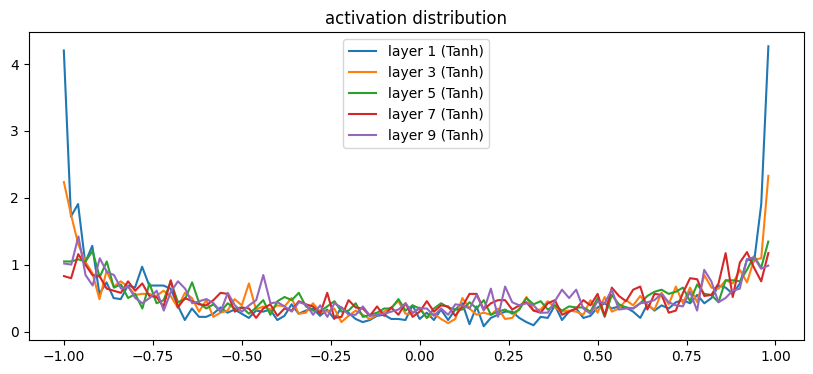

In [164]:
legends = []
plt.figure(figsize=(10, 4))
for i, layer in  enumerate(layers[:-1]):
    if isinstance(layer, Tanh):
        t = layer.out
        print('layer %d (%10s): mean: %+.2f std: %.2f saturated: %.2f%%' %(i, layer.__class__.__name__, t.mean(), t.std(), (t > 0.97).float().mean() * 100))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__})')

plt.legend(legends)
plt.title('activation distribution')
plt.show()

layer 1 (      Tanh): mean: -0.00 std: 0.00
layer 3 (      Tanh): mean: -0.00 std: 0.00
layer 5 (      Tanh): mean: -0.00 std: 0.00
layer 7 (      Tanh): mean: +0.00 std: 0.00
layer 9 (      Tanh): mean: +0.00 std: 0.00


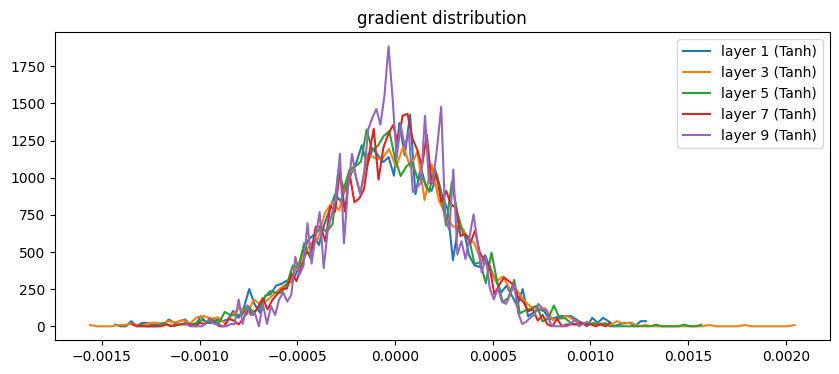

In [165]:
legends = []
plt.figure(figsize=(10, 4))
for i, layer in enumerate(layers[:-1]):
    if isinstance(layer, Tanh):
        t = layer.out.grad
        print('layer %d (%10s): mean: %+.2f std: %.2f' %
              (i, layer.__class__.__name__, t.mean(), t.std()))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__})')

plt.legend(legends)
plt.title('gradient distribution')
plt.show()

In [149]:
layer.out.grad

C:\Users\aniat\AppData\Local\Temp\ipykernel_2080\3102222648.py:1: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at aten\src\ATen/core/TensorBody.h:494.)
  layer.out.grad


In [117]:
hy, hx = torch.histogram(t, density=True)

In [123]:
hx.shape, hy.shape

(torch.Size([101]), torch.Size([100]))

tensor(1.0063) tensor(1.0047)


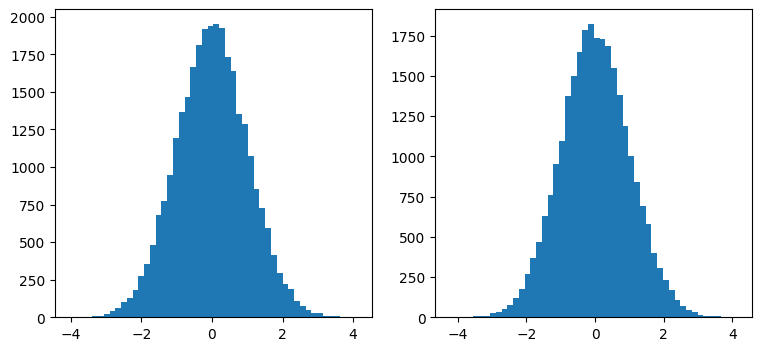

In [56]:
print(x.std(), w.std())
plt.figure(figsize=(9, 4))
plt.subplot(121)
plt.hist(x.flatten().tolist(), 50)
plt.subplot(122)
plt.hist(w.flatten().tolist(), 50)
plt.show()

In [57]:
logits = x @ w
logits.shape

torch.Size([30, 27])

tensor(31.2045)


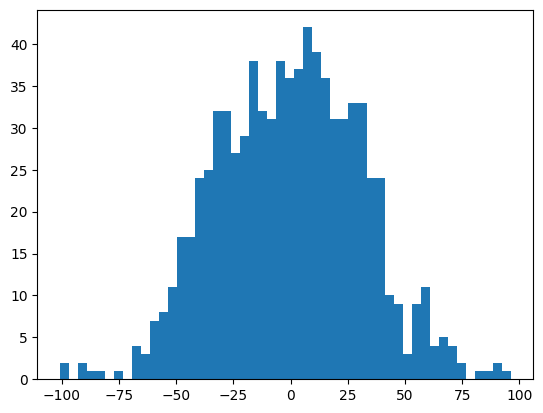

In [59]:
print(logits.std())
plt.hist(logits.flatten().tolist(), 50)
plt.show()

tensor(-2.3548e-09) tensor(1.4757)


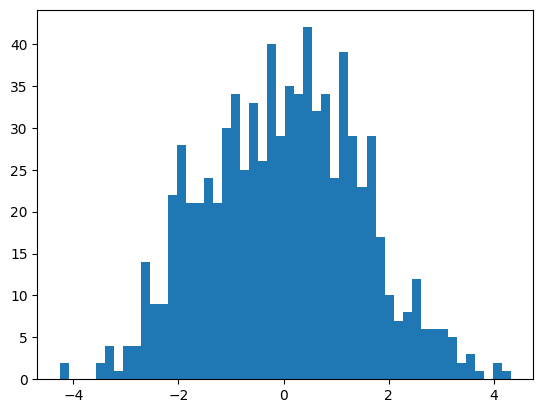

In [62]:
gamma = 1.5
bita = 0
logitsnorm = gamma * (logits - logits.mean(0, keepdim=True)) / logits.std(0, keepdim=True) + bita
print(logitsnorm.mean(), logitsnorm.std())

plt.hist(logitsnorm.flatten(), 50)
plt.show()